# Lecture 4: Programming HDRG Decoders
### James R. Wootton, IBM Quantum



In [13]:
from qiskit_qec.utils import Decodoku
from qiskit_qec.decoders import DecodingGraph
from rustworkx.visualization import mpl_draw
import numpy as np

## Beyond matching with qudit codes

We usually consider doing quantum computing with qubits: two-level quantum systems. But we could also do it with higher dimensional systems. We call these *qudits*. We can label the states `0`, `1`, ..., `k-1`, where $k$ here is the qudit dimension.

Just as we can define things like surface codes and repetition codes for qubits, we can do so for qudits too. Consider again the repetition code as a simple example. Before our syndrome measurements had two possible outcomes:
    * `0` implies neighbouring code qubits in the same state (`00` or `11`);
    * `1` implies neighbouring code qubits in different states (`01` or `01`).
By extracting only this information, we learn nothing about whether the code qubits are individually `0` or `1`, which means that the syndrome measurement doesn't destroy superpositions.

For `k=3` qudits, there are more ways that the code qudits can differ. Our syndrome can give us this additional information.
* `0` implies neighbouring code qubits in the same state (`00`, `11` or `22`);
* `1` implies the right one is one higher than the left (`01`, `12` or `20`);
* `2` implies the right one is two higher than the left (`02`, `10` or `21`);

Let's consider a few examples of what this looks like in practice. Here's 7 (qu)dits encoding a logical `0`, and the resulting (trivial) syndrome.

`0000000` $\,\, \rightarrow \,\,$ `000000`

Now suppose an error flips one of the values. The two affected syndromes will give non-trivial values. But they'll give differnt values depending on the nature of the flip. Here's an example of a $+1$ flip, which adds $1$ (mod 3).

`0010000` $\,\, \rightarrow \,\,$ `012000`

And here's a $+2$ flip in a different position.

`0002000` $\,\, \rightarrow \,\,$ `002100`

Now let's look at what happens when we have both.

`0012000` $\,\, \rightarrow \,\,$ `011100`

Note that the syndrome here has three non-trivial values. For this code, highlighted nodes are not created in pairs. Instead they are created in clusters, for which the values sum to 3.

In general for such codes, sets of errors create a cluster of highlighted nodes whose values add up to a multiple of $k$.

For these codes, we can't just use matching. So let's have a look at the kind of algorithms that do work.

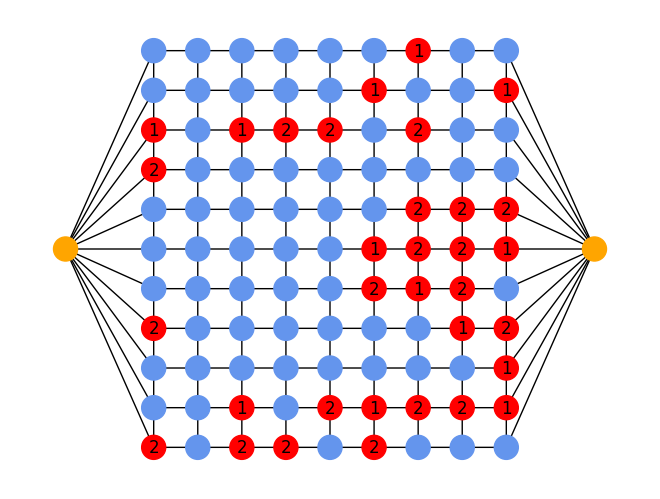

In [3]:
game = Decodoku(k=3,p=0.1)

game.draw_graph()

As ever, it will be useful to have a notion of distance between nodes. Let's with the standard Manhattan distance. In the Decodoku problems, this is also the number of nodes connecting edges.

In [4]:
def get_manhattan_distance(graph, n0, n1):
    node0 = graph[n0]
    node1 = graph[n1]
    dx = abs(node0['x']-node1['x'])
    if node0['is_boundary'] or node1['is_boundary']:
        dy = 0
    else:
        dy = abs(node0['y']-node1['y'])
    return dx + dy

get_distance = get_manhattan_distance

Now we'll again do something much like we did for matching: set up a new graph whose structure depends on where the highlighted nodes are.

This we'll make what we'll call a `cluster_graph`. This is basically the same as the `error_graph` from last time, but we'll leave all the non-highlighted nodes in.

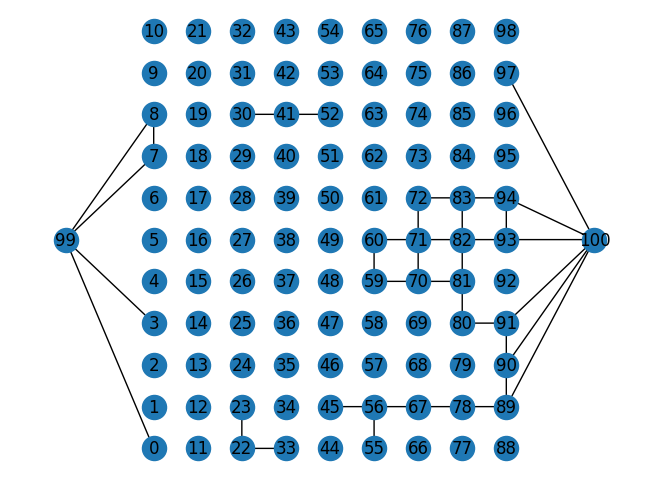

In [5]:
# set maximum distance
dist_max = 1

# get useful info
d = game.d
dg = game.decoding_graph.graph

# create empty `DecodingGraph`
cluster_graph = DecodingGraph(None)
cg = cluster_graph.graph

# add all nodes from dg
for node in dg.nodes():
    cg.add_node(node)
    if node['is_boundary']:
        # set boundary values to be nan
        node['value'] = np.nan

# add an edge between a pair of nodes if their distance is small enough
for n0, node0 in enumerate(dg.nodes()):
    for n1, node1 in enumerate(dg.nodes()):
        if n0<n1:
            dist = get_distance(dg,n0,n1)
            if dist<=dist_max:
                if (node0['highlighted'] or node0['is_boundary']) and (node1['highlighted'] or node1['is_boundary']):
                    cg.add_edge(n0, n1, {'distance':get_distance(dg,n0,n1)})

mpl_draw(cg, pos=game.graph_pos, with_labels=True)

We'll now find the connected components of this graph, and then see if the parity of all their nodes is neutral. If so, we can conclude that they were created by the same set of errors.

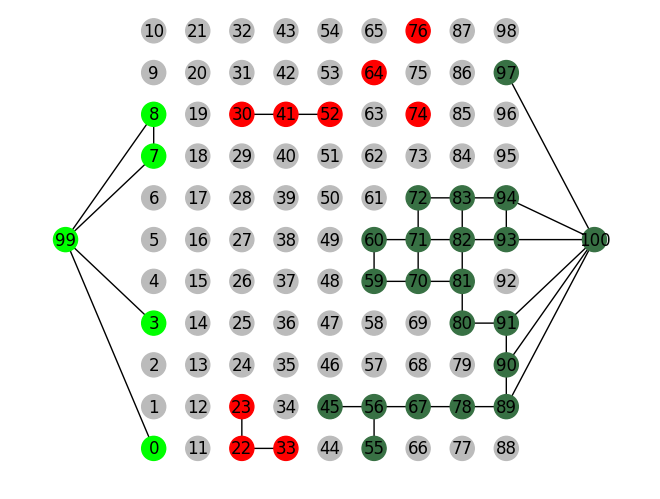

In [6]:
from rustworkx import connected_components

# find the connected components of cg
con_comps = connected_components(cg)

# use these to define clusters
clusters = {}
parity = {}
for c,con_comp in enumerate(con_comps):

    # check the parity of each connected component
    parity[c] = 0
    for n in con_comp:
        parity[c] += dg[n]['value']
    parity[c] = parity[c]%game.k
    # note that boundary connected components will have a parity of nan

    # if neutral (or boundary connected), it's a cluster
    # otherwise we tag highlighed nodes as being part of non-neutral clusters
    for n in con_comp:
        if dg[n]['highlighted'] or dg[n]['is_boundary']:
            if parity[c]==0 or parity[c]!=parity[c]:
                clusters[n] = c
            else:
                clusters[n] = 'non-neutral'
        else:
            clusters[n] = None

# assign colours to nodes based on their status:
# * a different colour for each node
# * red for highlighted nodes not in neutral clusters
# * light grey for the rest
node_color = ['#bbbbbb']*len(dg)
for n in clusters:
    if clusters[n] is not None:
        if clusters[n]=='non-neutral':
            node_color[n] = 'red'
        else:
            node_color[n] = game.error_colors[clusters[n]]

mpl_draw(cg, pos=game.graph_pos, node_color=node_color, with_labels=True)

Once we've decided that these edges contain errors, we could use this information to modify the decoding graph. Effectively we combine these clusters into a single neutral node.

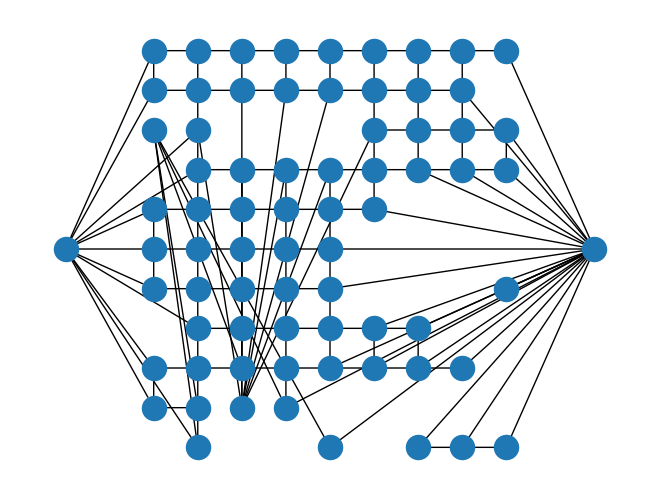

In [7]:
reduced_dg = dg.copy()
# copy the positions for dg and add some empty spaces
reduced_pos = game.graph_pos + [None]*100

for c,con_comp in enumerate(con_comps):
    if len(con_comp)>1:
        con_comp = list(con_comp)
        new_n = reduced_dg.contract_nodes(con_comp,c)
        if parity[c]==0:
            reduced_pos[new_n] = reduced_pos[con_comp[0]]
        if parity[c]!=parity[c]:
            for n in con_comp:
                if dg[n]['is_boundary']:
                    reduced_pos[new_n] = reduced_pos[n]

mpl_draw(reduced_dg, pos=reduced_pos)

There are various decoders that we could define that are based on this kind of information. So let's combine all this into a handy function.

In [8]:
def cluster(game, dist_max):

    # get useful info
    d = game.d
    dg = game.decoding_graph.graph

    # create empty `DecodingGraph`
    cluster_graph = DecodingGraph(None)
    cg = cluster_graph.graph

    # add all nodes from dg
    for node in dg.nodes():
        cg.add_node(node)
        if node['is_boundary']:
            # set boundary values to be nan
            node['value'] = np.nan

    # add an edge between a pair of nodes if their distance is small enough
    for n0, node0 in enumerate(dg.nodes()):
        for n1, node1 in enumerate(dg.nodes()):
            if n0<n1:
                dist = get_distance(dg,n0,n1)
                if dist<=dist_max:
                    if (node0['highlighted'] or node0['is_boundary']) and (node1['highlighted'] or node1['is_boundary']):
                        cg.add_edge(n0, n1, {'distance':get_distance(dg,n0,n1)})

    # find the connected components of cg
    con_comps = connected_components(cg)

    # use these to define clusters
    clusters = {}
    parity = {}
    for c,con_comp in enumerate(con_comps):

        # check the parity of each connected component
        parity[c] = 0
        for n in con_comp:
            parity[c] += dg[n]['value']
        parity[c] = parity[c]%game.k
        # note that boundary connected components will have a parity of nan

        # if neutral (or boundary connected), it's a cluster
        # otherwise we tag highlighed nodes as being part of non-neutral clusters
        for n in con_comp:
            if dg[n]['highlighted'] or dg[n]['is_boundary']:
                if parity[c]==0 or parity[c]!=parity[c]:
                    clusters[n] = c
                else:
                    clusters[n] = 'non-neutral'
            else:
                clusters[n] = None

    # assign colours to nodes based on their status:
    # * a different colour for each node
    # * red for highlighted nodes not in neutral clusters
    # * dark grey for the rest
    node_color = ['#bbbbbb']*len(dg)
    for n in clusters:
        if clusters[n] is not None:
            if clusters[n]=='non-neutral':
                node_color[n] = 'red'
            else:
                node_color[n] = game.error_colors[clusters[n]]

    reduced_dg = dg.copy()
    # copy the positions for dg and add some empty spaces
    reduced_pos=game.graph_pos + [None]*100

    for c,con_comp in enumerate(con_comps):
        if len(con_comp)>1:
            con_comp = list(con_comp)
            new_n = reduced_dg.contract_nodes(con_comp,c)
            if parity[c]==0:
                reduced_pos[new_n] = reduced_pos[con_comp[0]]
            if parity[c]!=parity[c]:
                for n in con_comp:
                    if dg[n]['is_boundary']:
                        reduced_pos[new_n] = reduced_pos[n]

    return cg, node_color, reduced_dg, reduced_pos

## The basic flow of HDRG decoders

Hard decision renormalization group decoders use an increasing search distance to look for how to explain highlighted nodes, and then make final decisions on how to do this. Once everything had been explained, they stop.

With the tools we have so far, let's look at some decoding problems to get a sense of how HDRG decoders work.

In [9]:
game = Decodoku(k=3,p=0.08,d=13)

First we should look at the graph.

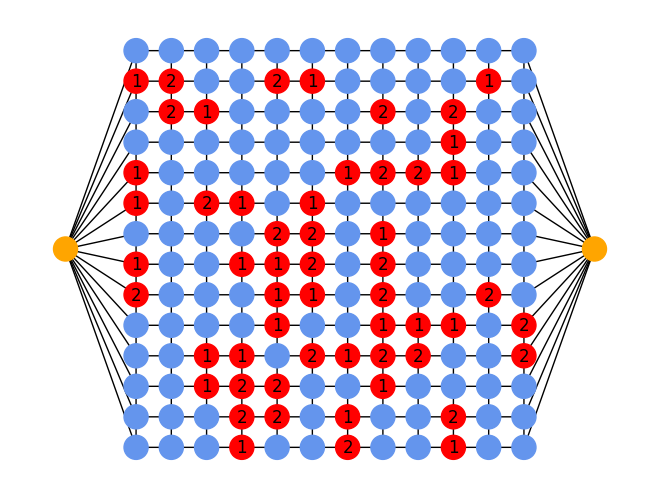

In [10]:
game.draw_graph()

Then let's look at how they cluster for a small distance.

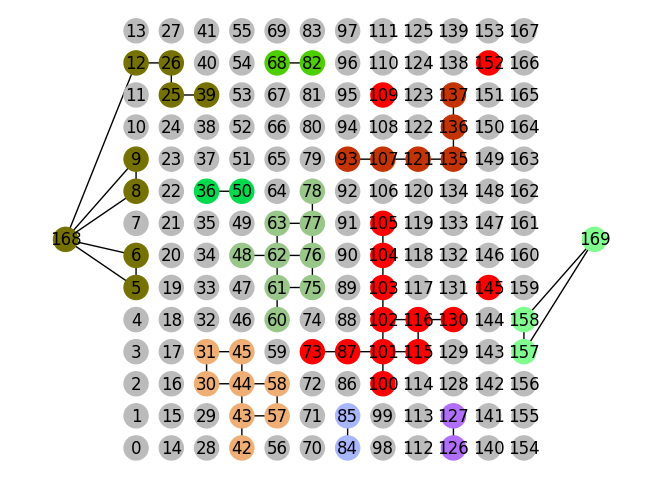

In [11]:
dist_max = 1
cg, node_color, reduced_dg, reduced_pos = cluster(game, dist_max) 

mpl_draw(cg, pos=game.graph_pos, node_color=node_color, with_labels=True)

We can then clean up all the neutral clusters found here.

In [12]:
game.run()

Before we continue, it might be good to keep in mind how this has affected the syndrome graph (since further analysis by the function here will have forgotten it).

In [ ]:
mpl_draw(reduced_dg, pos=reduced_pos)

Now let's head back up to the clustering and increase `dist_max`.

## The history of HDRG decoders

Here's a list important papers (slightly biased towards the person writing the list).
* 2011 **Bravyi-Haah**: [Bravyi and Haah](https://arxiv.org/abs/1112.3252).
* 2004 and 2013 **Expanding diamonds**: [Harrington](https://thesis.library.caltech.edu/1747/), [Dennis](arXiv:quant-ph/0503169) and [Wootton](https://arxiv.org/abs/1310.2393).
* 2013 **ABCB**: [Anwar, Brown, Campbell, Browne](https://arxiv.org/abs/1311.4895).
* 2014 **Shortcuts and matching**: [Hutter, Loss and Wootton](https://arxiv.org/abs/1410.4478).
* 2017 **Weasel**: [Wootton](https://arxiv.org/abs/1712.09649) (inspired by results from the Decodoku citizen science project).
* 2017 **Union-Find**: [Delfosse and Nickerson](https://arxiv.org/abs/1709.06218).

The algorithms these present differ in how they increase the search distance, and how they account for clusters that have already been removed.

### Bravyi-Haah, Expanding diamonds and ABCB

For *expanding diamonds*, it's best to go back to the qubit case and do it manually. In this we increase a search distance, and remove neutral clusters as soon as possible.

In [ ]:
game = Decodoku(k=2,p=0.1)
game.run()


For *Bravyi-Haah* we use the Chebyshev distance rather than Manhattan, which means $\max(dx,dy)$ instead of $dx+dy$. Also, we increase the search distance exponentially. We can implement this by redfining the distance below and going back to the basic flow.

In [ ]:
def get_chebyshev_distance(graph, n0, n1):
    node0 = graph[n0]
    node1 = graph[n1]
    dx = abs(node0['x']-node1['x'])
    if node0['is_boundary'] or node1['is_boundary']:
        dy = 0
    else:
        dy = abs(node0['y']-node1['y'])
    return max(dx,dy)

get_distance = get_chebyshev_distance

In [ ]:
game = Decodoku(k=3,p=0.05,d=13)

In [ ]:
dist_max = 2**0
cg, node_color, reduced_dg, reduced_pos = cluster(game, dist_max) 

mpl_draw(cg, pos=game.graph_pos, node_color=node_color, with_labels=True)

The ABCB decoder uses the Manhattan distance and a linearly increasing distance.

In [ ]:
get_distance = get_manhattan_distance

### Cantor-like error chains, shortcuts and Weasel

Suppose we have the following set of errors, expressed in ASCII art. Here `*` is a highlighted node, `-` is an error and the numbers represent distances.

```
      2    2       2    2                2    2       2    2 
    *--* *--*    *--* *--*             *--* *--*    *--* *--*
        1      4     1           13        1      4     1    
```

The HDRG decoders we've seen so far would typically notice the pairs separated by distance 1 and 'correct' them. But actually, this would create longer error chains.

```
      2    2       2    2                2    2       2    2 
    *--·~·--*    *--·~·--*             *--·~·--*    *--·~·--*
        1      4     1           13        1      4     1    
```

Then they'd do the same to those separated by distance 4.

```
      2    2       2    2                2    2       2    2 
    *--·~·--·~~~~·--·~·--*             *--·~·--·~~~~·--·~·--*
        1      4     1           13        1      4     1    
```

And so on

```
      2    2       2    2                2    2       2    2 
    *--·~·--·~~~~·--·~·--·~~~~~~~~~~~~~·--·~·--·~~~~·--·~·--*
        1      4     1           13        1      4     1    
```

These Cantor-like error chains can be a big problem, since they can cause logical errors with much less than $d/2$ physical errors.

Specifically, they are made up by a copying a structure. Between the copies we put a gap that is slightly smaller than the width of the structure.

In [ ]:
from matplotlib import pyplot as plt

# number of errors in each level
errors = [2]
# length of each level
length = [2]

# repeat the process for multiple levels
for _ in range(20):

    # each level has twice the errors as the last
    errors.append(errors[-1]*2)
    # and (almost) 3x the distance
    length.append(2*length[-1] + length[-1]-1)

plt.scatter(length,errors)

Assuming that the number of errors $n_e$ and the length of the error chain $l$ are related according to $n_e \sim l^\beta$, then

$\log{n_e} \sim \log{l^\beta} = \beta \log{l}$.

So we'll be able to find $\beta$ as the gradient of a log-log plot.

In [ ]:
plt.scatter(np.log(length),np.log(errors))


Clearly $\beta < 1$. So our effective code distance is no longer $d$, but scales as $d^\beta$. Just because of the decoder!

One way to get around this is to use 'shortcuts': take into account the reduced distances as clusters are combined.

Another way, used by the *Weasel* decoder, is to keep neutral clusters around. The method here is basically:
* Each non-neutral cluster merges with its nearest neighbouring cluster (neutral or non-neutral);
* Repeat. 

## Non-Abelian decoding

So far we've been able to use a very important piece of information: we know how the syndrome would change if we modified the set of errors. But that's not always the case, such as with codes whose syndromes are described by non-Abelian anyons.

The simplest are the [non-cyclic anyon models](https://arxiv.org/abs/1607.02159), in which information can be fully resolved in a finite number of rounds (assuming no new errors).

An example of the kind of behaviour found for Ising anyons can be seen in the problem below.

In [ ]:
game = Decodoku(k=4,p=0.05,d=11,nonabelian=True)

game.run()

More complex is the decoding of non-cyclic anyon models, as described [here](https://arxiv.org/pdf/1506.00524.pdf). It was only recently that it was shown that a threshold even exists for such models, in [this paper](https://arxiv.org/abs/2012.04610).

In [ ]:
game = Decodoku(k=6,p=0.05,d=11,nonabelian=True)

game.run()

## Open Problems

A few open problems related to the issues discussed here.

* What is the minimal fatal error for the Weasel decoder?
* How well does Union Find work for:
    * Qudit codes?
    * Non-Abelian decoding?